# 1. Importación de librerías y carga de datos

In [1]:
# Ni escalado ni estandarizado
SCALED=False
STANDARIZED=False

In [2]:
# Importamos las librerías necesarias

import haversine as hs
import pandas as pd
import numpy as np
import pickle
import time
import os

import tensorflow as tf
tf.config.run_functions_eagerly(True)
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.layers import LSTM, GRU, Dense, Reshape, Dropout, Bidirectional, \
  RepeatVector, TimeDistributed, Conv1D, MaxPooling1D, Flatten, ConvLSTM2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from haversine import inverse_haversine, Direction
from attention import Attention

if SCALED:
    from sklearn.preprocessing import MinMaxScaler
elif STANDARIZED:
    from sklearn.preprocessing import StandardScaler

from shapely import geometry
import geopy
import geopy.distance
import math

import matplotlib.pyplot as plt

from codecarbon import EmissionsTracker

C:\Users\sandr\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [3]:
# Hacemos el resultado reproducible
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

# Declaramos el tipo de float, en este caso float64
tf.keras.backend.set_floatx('float64')

In [4]:
# Leemos y guardamos la info de segudo y vehículo
df = pd.read_csv('positions.csv')

df_data = df.sort_values(by=['vehicle_id', 'time(s)'])

columns = ['time(s)', 'vehicle_id']
df = df_data[columns]
df.head()

C:\Users\sandr\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,time(s),vehicle_id
0,1.0,0
31,2.0,0
64,3.0,0
100,4.0,0
158,5.0,0


In [5]:
# Load MinMaxScaler for target variables
if SCALED:
    MINMAXSCALER_FILE = './minmaxscaler.pkl'#os.path.join("TFM", "implementation",
                             #"data_preparation", "minmaxscaler.pkl")
    with open(MINMAXSCALER_FILE, 'rb') as f_minmaxscaler:
        minmaxscaler = pickle.load(f_minmaxscaler)
if STANDARIZED:
    TARGETS_STAND_FILE = './' #os.path.join("TFM", "implementation",
                                     #"data_preparation", "targets_stand.pkl")
    with open(TARGETS_STAND_FILE, 'rb') as f_scaler:
        standscaler_targets = pickle.load(f_scaler)

In [6]:
# Load training dataset
if SCALED:
    DATASET_TRAIN = os.path.join('./',
                               "ventanas_no_coincidentes_train_val_scaled.npz")
elif STANDARIZED:
    DATASET_TRAIN = os.path.join('./',
                               "ventanas_no_coincidentes_train_val_stand.npz")
else:
    DATASET_TRAIN = os.path.join('./',
                               "ventanas_no_coincidentes_train_val.npz")
    
npzfile = np.load(DATASET_TRAIN)
X_train = npzfile['X_train']
X_val = npzfile['X_val']
y_train = npzfile['y_train']
y_val = npzfile['y_val']
print("X_train: {}  y_train: {}\nX_val: {}  y_val: {}"
      .format(X_train.shape, y_train.shape, X_val.shape, y_val.shape))

# Load testing dataset
if SCALED:
    DATASET_TEST = os.path.join('./',
                              "ventanas_no_coincidentes_test_scaled.npz")
elif STANDARIZED:
    DATASET_TEST = os.path.join('./',
                              "ventanas_no_coincidentes_test_stand.npz")
else:
    DATASET_TEST = os.path.join('./',
                              "ventanas_no_coincidentes_test.npz")
npzfile = np.load(DATASET_TEST)
X_test = npzfile['X_test']
y_test = npzfile['y_test']
print("X_test: {}  y_test: {}".format(X_test.shape, y_test.shape))

# Load testing vehicle ids list
VEHICLE_IDS_FILE = os.path.join('./', "vehicle_ids.pkl")
with open(VEHICLE_IDS_FILE, 'rb') as f_vehicle_ids:
    vehicle_ids = pickle.load(f_vehicle_ids)
print("Vehicle_ids: {}".format(len(vehicle_ids)))

X_train: (6005877, 20, 5)  y_train: (6005877, 5, 5)
X_val: (2573948, 20, 5)  y_val: (2573948, 5, 5)
X_test: (2402, 20, 5)  y_test: (2402, 5, 5)
Vehicle_ids: 8972


In [7]:
# Load dataset with vehicles dimensions
DATASET_DIM = os.path.join('./', "dimensions.csv")
df_dim = pd.read_csv(DATASET_DIM)
df_dim = df_dim[['vehicle_id', 'length', 'width']]
df_dim.head()

,vehicle_id,length,width
0,0,5.0,1.8
1,2,5.0,1.8
2,3,5.0,1.8
3,4,2.2,0.9
4,5,5.0,1.8


In [8]:
# Load dataset with vehicles colision
#DATASET_COL = os.path.join('./', "collisions_1k.csv")
df_col = pd.read_csv('collisions_2k.csv')
df_col = df_col[['vehicle_id', 'victim_id']].astype(int)
df_col.head()

,vehicle_id,victim_id
0,1240,5722
1,209,802
2,863,300
3,6444,3528
4,798,2787


In [9]:
# Load dataset with vehicles no-colision
#DATASET_NOCOL = os.path.join('./', "no_collisions_1k.csv")
df_nocol = pd.read_csv('no_collisions_2k.csv')
df_nocol = df_nocol[['v1', 'v2']]
df_nocol.head()

,v1,v2
0,31477,34003
1,33063,33228
2,33130,33973
3,33268,33958
4,33268,34256


In [10]:
df_col.shape

(2120, 2)

In [11]:
df_nocol.shape

(2120, 2)

# 2. Generación y entrenamiento de los modelos

In [12]:
#if SCALED:
#    MODELS_FOLDER = os.path.join("TFM", "implementation", "models", "scaled")
#elif STANDARIZED:
#    MODELS_FOLDER = os.path.join("TFM", "implementation", "models", "standarized")
#else:
#    MODELS_FOLDER = os.path.join("TFM", "implementation", "models", "real")
    
MODELS_FOLDER = './'

In [13]:
# Windows parameters
INPUT_WIDTH=20
OUTPUT_WIDTH=5
OFFSET_WIDTH=0

# Input and output columns
INPUT_COL = ['latitude(m)', 'longitude(m)', 'heading', 'speed(m/s)', 'acceleration(m/s²)']
OUTPUT_COL = ['latitude(m)', 'longitude(m)', 'heading', 'speed(m/s)', 'acceleration(m/s²)']

# Training parameters
EPOCHS= 10
BATCH_SIZE=64
PATIENCE=3
REDUCELR=0.2

def compile_and_fit(model, X_train, y_train, X_val, y_val, folder, epochs=20,
                    batch_size=32, patience=2, learning_rate=0.001, reduce_lr=0):
    tracker = EmissionsTracker(log_level="error")
    callback_list = []

    # Return best model that minimize loss function
    early_stopping = EarlyStopping(
        monitor='val_loss', patience=patience*2, mode='min',
        restore_best_weights=True)
    callback_list.append(early_stopping)

    # Save best model that minimize loss function
    checkpoint_file = os.path.join(folder, 'model_saved.hdf5')
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_file, monitor='val_loss', mode="min",
        save_best_only=True, verbose=0)
    callback_list.append(checkpoint)
  
    if reduce_lr != 0:
        # Reduce learning rate to minimize loss function
        reduce_learningrate = ReduceLROnPlateau(
            monitor='val_loss', patience=patience, mode='min', factor=reduce_lr)
        callback_list.append(reduce_learningrate)

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=Adam(learning_rate=learning_rate),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])

    tracker.start()
    start_time = time.time()
    print('X_train.shape:', X_train.shape)
    print('y_train.shape:', y_train.shape)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                      validation_data=(X_val, y_val),
                      callbacks=callback_list)
    total_time = time.time() - start_time
    emissions = tracker.stop()

    # Save fit history
    history_pickle = os.path.join(folder, 'history.pkl')
    pickle.dump(history.history, open(history_pickle, 'wb'))

    # Print and write fit statistics
    min_val_loss = min(history.history['val_loss'])
    best_model_index = history.history['val_loss'].index(min_val_loss)
    print("\nTraining Loss (MSE): {}".format(history.history['loss'][best_model_index]))
    print("Validation Loss (MSE): {}".format(history.history['val_loss'][best_model_index]))
    print("Training MAE: {}".format(history.history['mean_absolute_error'][best_model_index]))
    print("Validation MAE: {}".format(history.history['val_mean_absolute_error'][best_model_index]))
    print("Execution time (s): {}".format(total_time))
    print("Emissions (kg): {}\n".format(emissions))
    stats_file = os.path.join(folder, "stats.txt")
    with open(stats_file, 'w') as f_stats:
        f_stats.write("Training Loss (MSE): {}\n".format(history.history['loss'][best_model_index]))
        f_stats.write("Validation Loss (MSE): {}\n".format(history.history['val_loss'][best_model_index]))
        f_stats.write("Training MAE: {}\n".format(history.history['mean_absolute_error'][best_model_index]))
        f_stats.write("Validation MAE: {}\n".format(history.history['val_mean_absolute_error'][best_model_index]))
        f_stats.write("Execution time (s): {}\n".format(total_time))
        f_stats.write("Emissions (kg): {}\n".format(emissions))

    return history


def plot_history(history, start=None, end=None):
    train_loss = history['loss'][start:end]
    val_loss = history['val_loss'][start:end]
    train_mae = history['mean_absolute_error'][start:end]
    test_mae = history['val_mean_absolute_error'][start:end]

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax[0].plot(train_loss, label="Train")
    ax[0].plot(val_loss, label="Validation")
    ax[0].set_title("Training and Validation loss")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Loss")
    ax[0].legend()

    ax[1].plot(train_mae, label="Train")
    ax[1].plot(test_mae, label="Validation")
    ax[1].set_title("Training and Validation MAE")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Mean Absolute Error")
    ax[1].legend()

    plt.show()


def model_predictions(model, X_test, y_test):
    def calculate_haversine(coord1, coord2):
        return hs.haversine(coord1, coord2, unit=hs.Unit.METERS)

    y_pred = model.predict(X_test)
    if SCALED:
        y_pred = minmaxscaler.inverse_transform(y_pred.reshape(-1, 2))
    elif STANDARIZED:
        y_pred = standscaler_targets.inverse_transform(y_pred.reshape(-1, 2))
    y_pred = y_pred.reshape(-1, 5)

    if SCALED:
        y_test = minmaxscaler.inverse_transform(y_test.reshape(-1, 2))
    elif STANDARIZED:
        y_test = standscaler_targets.inverse_transform(y_test.reshape(-1, 2))
    y_test = y_test.reshape(-1, 5)

    df_y_pred = pd.DataFrame(
        y_pred, columns=['latitude(pred)', 'longitude(pred)','heading(pred)', 'speed(m/s)(pred)', 'acceleration(m/s²)(pred)'])
    df_y_test = pd.DataFrame(y_test, columns=['latitude', 'longitude', 'heading', 'speed(m/s)', 'acceleration(m/s²)'])
    df_pred = pd.concat([df_y_pred, df_y_test], axis=1)

    distance = df_pred.apply(
        lambda row: calculate_haversine((row['latitude(pred)'], row['longitude(pred)']),
                                        (row['latitude'], row['longitude'])), axis=1)
    df_pred['distance(m)'] = distance

    return df_pred

In [14]:
import warnings
warnings.filterwarnings('ignore')

def bearing_calc(a_lat, a_lon, b_lat, b_lon): # a previous position b current position
    rlat1 = math.radians(a_lat)
    rlon1 = math.radians(a_lon)
    rlat2 = math.radians(b_lat)
    rlon2 = math.radians(b_lon)
    dlon = math.radians(b_lon - a_lon)
    b = math.atan2(
      math.sin(dlon)*math.cos(rlat2),
      math.cos(rlat1)*math.sin(rlat2)-math.sin(rlat1)*math.cos(rlat2)*math.cos(dlon))  # bearing calc
    bd = math.degrees(b)
    br, bn = divmod(bd + 360, 360)  # the bearing remainder and final bearing
    return bn


# To get a rotated rectangle at a bearing, you need to get the points of the the recatangle at that bearing
def get_rotated_points(coordinates, bearing, width, length):
    start = geopy.Point(coordinates)
    width = width/1000
    length = length/1000
    rectlength = geopy.distance.distance(kilometers=length)
    rectwidth = geopy.distance.distance(kilometers=width)
    halfwidth = geopy.distance.distance(kilometers=width/2)
    halflength = geopy.distance.distance(kilometers=length/2)

    pointAB = halflength.destination(point=start, bearing=bearing)
    pointA = halfwidth.destination(point=pointAB, bearing=0 - bearing)
    pointB = rectwidth.destination(point=pointA, bearing=180 - bearing)
    pointC = rectlength.destination(point=pointB, bearing=bearing - 180)
    pointD = rectwidth.destination(point=pointC, bearing=0 - bearing)

    points = []
    for point in [pointA, pointB, pointC, pointD]:
        coords = (point.latitude, point.longitude)
        points.append(coords)

    return points

def get_colision(v1_id, v2_id, X_test_v1, X_test_v2, dimensions, model):
    colision = 0

    y_pred_v1 = model.predict(X_test_v1.reshape(1, 20, 5), verbose=0)
    if SCALED:
        y_pred_v1 = minmaxscaler.inverse_transform(y_pred_v1.reshape(-1, 2))
    elif STANDARIZED:
        y_pred_v1 = standscaler_targets.inverse_transform(y_pred_v1.reshape(-1, 2))
    y_pred_v1 = y_pred_v1.reshape(-1, 5)
    v1_coord_5 = y_pred_v1[-1]
  # v1_coord_4 = y_pred_v1[-2]

    v1_length = dimensions[dimensions['vehicle_id'] == v1_id].iloc[0, 1]
    v1_width = dimensions[dimensions['vehicle_id'] == v1_id].iloc[0, 2]

  # v1_bearing = bearing_calc(v1_coord_4[0], v1_coord_4[1],
  #                           v1_coord_5[0], v1_coord_5[1])
    v1_points = get_rotated_points(tuple(v1_coord_5[:2]), v1_coord_5[-1],
                                 v1_width, v1_length)
    polygon1 = geometry.Polygon(v1_points)

    y_pred_v2 = model.predict(X_test_v2.reshape(1, 20, 5), verbose=0)
    if SCALED:
        y_pred_v2 = minmaxscaler.inverse_transform(y_pred_v2.reshape(-1, 5))
    elif STANDARIZED:
        y_pred_v2 = standscaler_targets.inverse_transform(y_pred_v2.reshape(-1, 2))
    y_pred_v2 = y_pred_v2.reshape(-1, 5)
    v2_coord_5 = y_pred_v2[-1]
  # v2_coord_4 = y_pred_v2[-2]

    v2_length = dimensions[dimensions['vehicle_id'] == v2_id].iloc[0, 1]
    v2_width = dimensions[dimensions['vehicle_id'] == v2_id].iloc[0, 2]

  # v2_bearing = bearing_calc(v2_coord_4[0], v2_coord_4[1],
  #                           v2_coord_5[0], v2_coord_5[1])
    v2_points = get_rotated_points(tuple(v2_coord_5[:2]), v2_coord_5[-1],
                                 v2_width, v2_length)
    polygon2 = geometry.Polygon(v2_points)

    if polygon1.intersection(polygon2).area > 0.0:
        colision = 1
  
    return colision

def get_metrics(model, X_test, df, vehicle_ids, df_col, df_nocol, df_dim,
                metrics_file):
    total_colision = 0
    total_no_colision = 0

    true_positive = 0
    false_negative = 0
    false_positive = 0
    true_negative = 0

    # Vehiculos que coinciden y colisionan
    print('coinciden y colisionan:', df_col.shape[0])
    i = 0
    while (true_positive + false_negative) < 1200 and i < df_col.shape[0]:
    #for i in range(df_col.shape[0]):
        if i%100 == 0:
            print(i)
        v1_id = df_col.iloc[i, 0]
        v2_id = df_col.iloc[i, 1]

        v1_ts_set = set(df[df['vehicle_id'] == v1_id].iloc[-5:, 0])
        v2_ts_set = set(df[df['vehicle_id'] == v2_id].iloc[-5:, 0])
        intersection = sorted(list(v1_ts_set.intersection(v2_ts_set)))
        if len(intersection) >= 2:
            total_colision += 1
            #v1_index = vehicle_ids.index(v1_id)
            #v2_index = vehicle_ids.index(v2_id)
            
            # Cogemos los 20 segundos antes de la intersección
            X_v1 = df_data.loc[(df_data['vehicle_id'] == v1_id) & 
                               (df_data['time(s)'].isin(range(int(min(v1_ts_set))-20, int(min(v1_ts_set))))),
                              INPUT_COL].values.tolist()
            X_v2 = df_data.loc[(df_data['vehicle_id'] == v2_id) & 
                               (df_data['time(s)'].isin(range(int(min(v2_ts_set))-20, int(min(v2_ts_set))))),
                              INPUT_COL].values.tolist()
            #if get_colision(v1_id, v2_id, X_test[v1_index], X_test[v2_index], df_dim, model):
            if len(X_v1) == 20 and len(X_v2) == 20 and get_colision(v1_id, v2_id, np.array(X_v1), np.array(X_v2), df_dim, model):
                true_positive += 1
            else:
                false_negative += 1
        i = i+1
            

    # Vehiculos que coinciden pero no colisionan
    print('coinciden pero no colisionan:', df_nocol.shape[0])
    i = 0
    while (false_positive + true_negative) < 1200 and i < df_nocol.shape[0]:
    #for i in range(df_nocol.shape[0]):
        if i%100 == 0:
            print(i)
        v1_id = df_nocol.iloc[i, 0]
        v2_id = df_nocol.iloc[i, 1]

        v1_ts_set = set(df[df['vehicle_id'] == v1_id].iloc[-5:, 0])
        v2_ts_set = set(df[df['vehicle_id'] == v2_id].iloc[-5:, 0])
        intersection = sorted(list(v1_ts_set.intersection(v2_ts_set)))
        if len(intersection) >= 2:
            total_no_colision += 1 
            #v1_index = vehicle_ids.index(v1_id)
            #v2_index = vehicle_ids.index(v2_id)
            
            # Cogemos los 20 segundos antes de la intersección
            X_v1 = df_data.loc[(df_data['vehicle_id'] == v1_id) & 
                               (df_data['time(s)'].isin(range(int(min(v1_ts_set))-20, int(min(v1_ts_set))))),
                              INPUT_COL].values.tolist()
            X_v2 = df_data.loc[(df_data['vehicle_id'] == v2_id) & 
                               (df_data['time(s)'].isin(range(int(min(v2_ts_set))-20, int(min(v2_ts_set))))),
                              INPUT_COL].values.tolist()
            
            #if get_colision(v1_id, v2_id, X_test[v1_index], X_test[v2_index], df_dim, model):
            if len(X_v1) == 20 and len(X_v2) == 20 and get_colision(v1_id, v2_id, np.array(X_v1), np.array(X_v2), df_dim, model):
                false_positive += 1
            else:
                true_negative += 1
        i = i+1

    print('false_positive:', false_positive)
    print('true_negative:', true_negative)
    accuracy = (true_positive+true_negative)/(true_positive+false_positive+false_negative+true_negative)
    precision = true_positive/(true_positive+false_positive) if (true_positive+false_positive) != 0 else 0
    recall = true_positive/(true_positive+false_negative) if (true_positive+false_negative) != 0 else 0
    F1_score = 2*(recall*precision)/(recall+precision) if (recall+precision) != 0 else 0
    specificity = true_negative/(true_negative+false_positive) if (true_negative+false_positive) != 0 else 0

    with open(metrics_file, 'w') as f_metrics:
        f_metrics.write("Total colision: {}\n".format(total_colision))
        f_metrics.write("TP: {}\n".format(true_positive))
        f_metrics.write("FN: {}\n".format(false_negative))
        f_metrics.write("Total no colision: {}\n".format(total_no_colision))
        f_metrics.write("FP: {}\n".format(false_positive))
        f_metrics.write("TN: {}\n\n".format(true_negative))
        f_metrics.write("Accuracy: {}\n".format(accuracy))
        f_metrics.write("Precision: {}\n".format(precision))
        f_metrics.write("Recall: {}\n".format(recall))
        f_metrics.write("F1 Score: {}\n".format(F1_score))
        f_metrics.write("Specificity: {}\n".format(specificity))


    print("Total colision: {}".format(total_colision))
    print("TP: {}".format(true_positive))
    print("FN: {}".format(false_negative))
    print("Total no colision: {}".format(total_no_colision))
    print("FP: {}".format(false_positive))
    print("TN: {}".format(true_negative))
    print()
    print("Accuracy: {}".format(accuracy))
    print("Precision: {}".format(precision))
    print("Recall: {}".format(recall))
    print("F1 Score: {}".format(F1_score))
    print("Specificity: {}".format(specificity))

## 2.1. Simples

In [15]:
def make_lstm_model(units, in_steps, out_steps, in_features, out_features):
    lstm_model = Sequential()

    # Shape [batch, time, in_features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    lstm_model.add(LSTM(
      units, input_shape=(in_steps, in_features)))

    # Shape => [batch, out_steps*out_features].
    lstm_model.add(Dense(out_steps*out_features))

    # Shape => [batch, out_steps, out_features].
    lstm_model.add(Reshape([out_steps, out_features]))

    lstm_model.summary()

    return lstm_model

### 2.1.1. Modelo LSTM (64 unidades)

#### 2.1.1.1. Creación y entrenamiento de la red

In [16]:
# Create model folder
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "simple_v3", "LSTM_64units")
os.makedirs(MODEL_FOLDER, exist_ok=True)

# Model parameters
LSTM_UNITS=64

# Create, compile and fit model
lstm_model = make_lstm_model(LSTM_UNITS, INPUT_WIDTH, OUTPUT_WIDTH,
                             len(INPUT_COL), len(OUTPUT_COL))
history = compile_and_fit(lstm_model, X_train, y_train, X_val, y_val,
                          MODEL_FOLDER, epochs=EPOCHS, batch_size=BATCH_SIZE,
                          patience=PATIENCE, reduce_lr=REDUCELR)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                17920     
                                                                 
 dense (Dense)               (None, 25)                1625      
                                                                 
 reshape (Reshape)           (None, 5, 5)              0         
                                                                 
Total params: 19,545
Trainable params: 19,545
Non-trainable params: 0
_________________________________________________________________
X_train.shape: (6005877, 20, 5)
y_train.shape: (6005877, 5, 5)
Epoch 1/10
93842/93842 [==============================] - 9968s 106ms/step - loss: 227.6023 - mean_absolute_error: 2.3173 - val_loss: 85.6497 - val_mean_absolute_error: 1.3125 - lr: 0.0010
Epoch 2/10
93842/93842 [==============================] - 9417s 

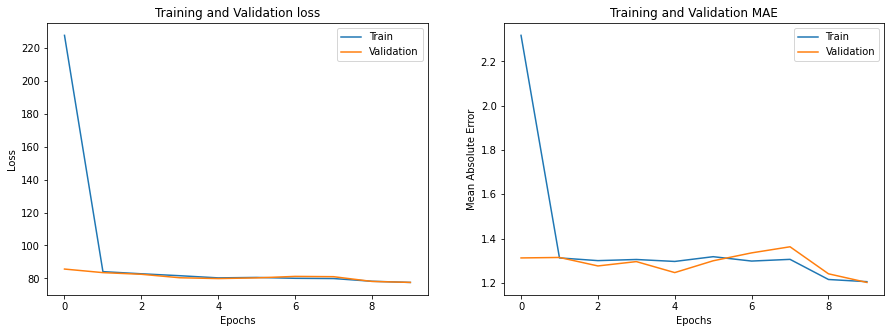

In [17]:
plot_history(history.history)

#### 2.1.1.2. Predicción de la red

In [18]:
df_pred = model_predictions(lstm_model, X_test, y_test)
print("Distance(m): [{}, {}]".format(min(df_pred['distance(m)']),
                                     max(df_pred['distance(m)'])))
df_pred

76/76 [==============================] - 2s 31ms/step
Distance(m): [11.652938990308316, 499840.61393746303]


,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
0,41.396181,2.151253,71.113997,0.295208,-0.007935,41.394340,2.151350,72.348077,0.000000,0.000000,204.828594
1,41.396205,2.151249,71.152991,0.378483,0.058823,41.394340,2.151350,72.348077,0.000000,0.000000,207.507661
2,41.396200,2.151214,71.419897,0.479679,0.076567,41.394340,2.151350,72.348077,0.000000,0.000000,207.096350
3,41.396178,2.151230,71.867207,0.601678,0.098560,41.394340,2.151350,72.348077,0.000000,0.000000,204.651382
4,41.396172,2.151208,72.219963,0.717012,0.102526,41.394340,2.151350,72.348077,0.000000,0.000000,204.032334
...,...,...,...,...,...,...,...,...,...,...,...
12005,41.402155,2.149318,51.581782,7.082663,-0.507803,41.400268,2.151179,44.652289,7.775367,0.289365,261.048913
12006,41.402252,2.149365,59.302844,6.811637,-0.373183,41.400317,2.151234,39.488036,7.149873,-0.625495,265.611343
12007,41.402274,2.149393,66.311568,6.741793,-0.165699,41.400383,2.151277,23.947936,8.208109,1.058236,262.506103
12008,41.402277,2.149442,73.377291,6.748886,-0.070169,41.400452,2.151264,348.255669,8.071555,-0.136553,253.464546


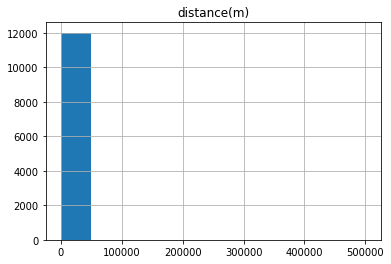

In [19]:
df_pred.hist('distance(m)')
plt.show()

In [20]:
n_rows = df_pred.shape[0]
list_1seg, list_2seg, list_3seg, list_4seg, list_5seg = \
  [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows

for i in range(n_rows):
    if i%5 == 0:
        list_1seg[i] = True
    elif i%5 == 1:
        list_2seg[i] = True
    elif i%5 == 2:
        list_3seg[i] = True
    elif i%5 == 3:
        list_4seg[i] = True
    elif i%5 == 4:
        list_5seg[i] = True

df_pred_1seg = df_pred.iloc[list_1seg, :]
df_pred_2seg = df_pred.iloc[list_2seg, :]
df_pred_3seg = df_pred.iloc[list_3seg, :]
df_pred_4seg = df_pred.iloc[list_4seg, :]
df_pred_5seg = df_pred.iloc[list_5seg, :]

In [21]:
print("Segundo 1: [{}, {}]".format(min(df_pred_1seg['distance(m)']),
                                   max(df_pred_1seg['distance(m)'])))
print("Segundo 2: [{}, {}]".format(min(df_pred_2seg['distance(m)']),
                                   max(df_pred_2seg['distance(m)'])))
print("Segundo 3: [{}, {}]".format(min(df_pred_3seg['distance(m)']),
                                   max(df_pred_3seg['distance(m)'])))
print("Segundo 4: [{}, {}]".format(min(df_pred_4seg['distance(m)']),
                                   max(df_pred_4seg['distance(m)'])))
print("Segundo 5: [{}, {}]".format(min(df_pred_5seg['distance(m)']),
                                   max(df_pred_5seg['distance(m)'])))

Segundo 1: [19.409961294448912, 494529.62331584154]
Segundo 2: [11.652938990308316, 499399.6784098431]
Segundo 3: [14.77958435037428, 499840.61393746303]
Segundo 4: [19.589720450689146, 493835.59180464724]
Segundo 5: [17.180574173765788, 492705.1090962323]


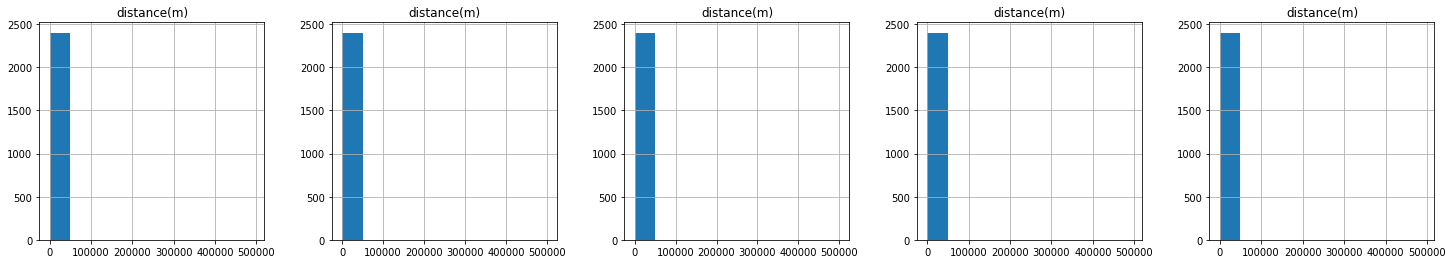

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25,4))
df_pred_1seg.hist('distance(m)', ax=ax[0])
df_pred_2seg.hist('distance(m)', ax=ax[1])
df_pred_3seg.hist('distance(m)', ax=ax[2])
df_pred_4seg.hist('distance(m)', ax=ax[3])
df_pred_5seg.hist('distance(m)', ax=ax[4])
plt.show()

In [23]:
df_pred_1seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.395144,2.149474,183.771171,5.435602,-0.103794,41.396994,2.149619,184.171392,5.743007,0.164075,776.058040
std,0.091245,0.002209,97.024334,4.787083,0.240884,0.002307,0.003671,98.232361,5.102721,1.308594,10122.213145
min,36.948922,2.071846,12.097342,-3.353034,-0.967037,41.390906,2.139125,0.939814,0.000000,-10.000000,19.409961
25%,41.395076,2.148478,104.986523,0.432485,-0.293571,41.395245,2.147242,101.919406,0.172846,-0.104516,231.331686
50%,41.396470,2.149729,153.529092,5.349930,-0.028835,41.396960,2.149929,155.247244,4.966377,0.000000,388.881054
75%,41.398989,2.150586,260.627486,9.929798,0.031336,41.398961,2.151950,256.275266,10.340684,0.774525,630.768177
max,41.544842,2.155327,330.767176,17.819035,1.276652,41.401814,2.158624,357.404922,16.640354,5.988961,494529.623316


In [24]:
df_pred_2seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.395149,2.149468,183.489521,5.316716,-0.133553,41.396996,2.149621,184.160835,5.890808,0.147801,780.415216
std,0.092141,0.002215,95.356116,4.532100,0.311612,0.002308,0.003673,98.298534,4.947635,1.448525,10221.605198
min,36.905130,2.071057,10.933925,-3.109358,-1.361684,41.390873,2.139078,0.939814,0.000000,-10.000000,11.652939
25%,41.395078,2.148468,109.201806,0.457582,-0.369643,41.395234,2.147314,101.844412,0.968818,-0.154634,230.774399
50%,41.396472,2.149710,153.403704,5.524622,-0.003072,41.396960,2.149913,155.264593,5.239587,0.030756,390.564673
75%,41.399034,2.150577,261.577756,9.547335,0.070178,41.398949,2.151951,256.443895,9.990617,0.898349,632.520460
max,41.545769,2.155265,332.989708,17.199888,1.171718,41.401864,2.158743,358.402101,16.602367,5.993102,499399.678410


In [25]:
df_pred_3seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.395148,2.149425,183.483491,5.178678,-0.147285,41.396996,2.149623,184.186244,6.081826,0.191018,779.688399
std,0.092219,0.002061,93.563089,4.234865,0.364305,0.002308,0.003675,98.566199,4.650839,1.636780,10230.179580
min,36.901062,2.081557,9.990999,-2.823281,-1.509016,41.390836,2.139009,0.373142,0.000000,-9.706740,14.779584
25%,41.395059,2.148440,112.369854,0.540048,-0.399439,41.395221,2.147382,103.263678,2.096294,-0.201319,231.668925
50%,41.396474,2.149641,154.252751,5.626519,0.016855,41.396951,2.149961,155.606261,5.454008,0.089373,391.627850
75%,41.399067,2.150529,261.022043,9.138636,0.109545,41.398932,2.151952,262.182490,9.341440,1.054450,631.166182
max,41.545086,2.155161,332.591619,16.137660,0.796165,41.401915,2.158883,359.323010,16.546956,5.998546,499840.613937


In [26]:
df_pred_4seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.395144,2.149437,183.584963,5.023973,-0.183214,41.396997,2.149625,183.173735,6.130936,0.049110,775.237385
std,0.091118,0.002158,91.718696,3.946417,0.362504,0.002309,0.003675,99.410339,4.357840,1.918388,10107.960480
min,36.955140,2.074480,9.385112,-2.554675,-1.464124,41.390802,2.138863,2.280386,0.000000,-10.000000,19.589720
25%,41.395042,2.148463,114.610242,0.604976,-0.445658,41.395206,2.147430,94.463904,2.726005,-0.410908,232.366344
50%,41.396447,2.149662,154.883994,5.655560,-0.007298,41.396931,2.150051,160.120137,5.748746,0.085084,388.723075
75%,41.399010,2.150541,259.655195,8.644227,0.061298,41.398903,2.151970,268.070273,8.739849,1.113957,627.600123
max,41.544585,2.155111,331.217289,14.988446,0.711667,41.401967,2.158981,359.017348,16.626126,5.996870,493835.591805


In [27]:
df_pred_5seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.395144,2.149402,183.505083,4.891692,-0.140127,41.396997,2.149628,176.707990,6.117309,0.105156,773.633910
std,0.090910,0.002057,89.706895,3.697672,0.309720,0.002309,0.003675,100.425471,4.092248,1.903228,10084.730963
min,36.965244,2.081614,11.838348,-2.610340,-1.173763,41.390767,2.138725,0.598478,0.000000,-10.000000,17.180574
25%,41.395020,2.148467,117.827312,0.704370,-0.380226,41.395191,2.147420,74.637179,3.188963,-0.242367,231.667592
50%,41.396433,2.149634,154.874231,5.671505,0.007212,41.396900,2.150056,147.086299,6.220898,0.103251,387.790256
75%,41.399002,2.150496,258.332808,8.255921,0.080582,41.398873,2.151995,261.391452,8.441894,1.059701,629.378010
max,41.544087,2.155015,329.735068,13.939387,0.555739,41.402028,2.159084,359.352131,16.601876,5.982253,492705.109096


#### 2.1.1.3. Métricas del modelo

In [28]:
# Load fitted model 
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "simple_v3", "LSTM_64units")
MODEL_FILE = os.path.join(MODEL_FOLDER, "model_saved.hdf5")
model = tf.keras.models.load_model(MODEL_FILE, compile=False) #https://stackoverflow.com/questions/48373845/loading-model-with-custom-loss-keras

# Get test metrics
METRICS_FILE = os.path.join(MODEL_FOLDER, "metrics.txt")
get_metrics(model, X_test, df, vehicle_ids, df_col, df_nocol, df_dim, METRICS_FILE)

coinciden y colisionan: 2120
0
100
200
300
400
500
600
700
800
900
1000
1100
coinciden pero no colisionan: 2120
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
false_positive: 12
true_negative: 1188
Total colision: 1200
TP: 3
FN: 1197
Total no colision: 1200
FP: 12
TN: 1188

Accuracy: 0.49625
Precision: 0.2
Recall: 0.0025
F1 Score: 0.0049382716049382715
Specificity: 0.99


In [29]:
# Create model folder
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "simple_v3", "LSTM_32units")
os.makedirs(MODEL_FOLDER, exist_ok=True)

# Model parameters
LSTM_UNITS=32

# Create, compile and fit model
lstm_model = make_lstm_model(LSTM_UNITS, INPUT_WIDTH, OUTPUT_WIDTH,
                             len(INPUT_COL), len(OUTPUT_COL))
history = compile_and_fit(lstm_model, X_train, y_train, X_val, y_val,
                          MODEL_FOLDER, epochs=EPOCHS, batch_size=BATCH_SIZE,
                          patience=PATIENCE, reduce_lr=REDUCELR)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                4864      
                                                                 
 dense_1 (Dense)             (None, 25)                825       
                                                                 
 reshape_1 (Reshape)         (None, 5, 5)              0         
                                                                 
Total params: 5,689
Trainable params: 5,689
Non-trainable params: 0
_________________________________________________________________
X_train.shape: (6005877, 20, 5)
y_train.shape: (6005877, 5, 5)
Epoch 1/10
93842/93842 [==============================] - 10094s 108ms/step - loss: 377.5518 - mean_absolute_error: 3.2486 - val_loss: 87.2506 - val_mean_absolute_error: 1.3856 - lr: 0.0010
Epoch 2/10
93842/93842 [==============================] - 10600

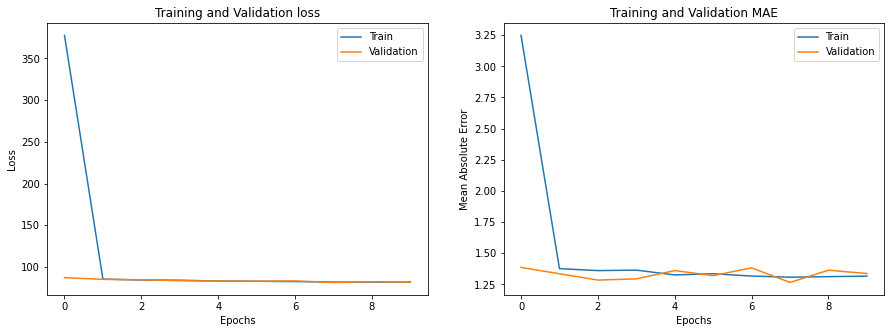

In [30]:
plot_history(history.history)

In [31]:
df_pred = model_predictions(lstm_model, X_test, y_test)
print("Distance(m): [{}, {}]".format(min(df_pred['distance(m)']),
                                     max(df_pred['distance(m)'])))
df_pred

76/76 [==============================] - 2s 28ms/step
Distance(m): [11.47682089556262, 1229.0909176069251]


,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
0,41.396073,2.151407,74.500323,0.221364,0.037089,41.394340,2.151350,72.348077,0.000000,0.000000,192.802875
1,41.396084,2.151411,74.297900,0.313748,0.112511,41.394340,2.151350,72.348077,0.000000,0.000000,194.030691
2,41.396097,2.151414,73.939017,0.411895,0.137009,41.394340,2.151350,72.348077,0.000000,0.000000,195.408045
3,41.396105,2.151413,73.589915,0.507940,0.141515,41.394340,2.151350,72.348077,0.000000,0.000000,196.311275
4,41.396104,2.151412,73.243564,0.596356,0.089663,41.394340,2.151350,72.348077,0.000000,0.000000,196.227238
...,...,...,...,...,...,...,...,...,...,...,...
12005,41.400195,2.150548,48.143189,7.115127,0.074038,41.400268,2.151179,44.652289,7.775367,0.289365,53.294631
12006,41.400284,2.150582,48.910915,7.281845,0.202846,41.400317,2.151234,39.488036,7.149873,-0.625495,54.461930
12007,41.400370,2.150613,50.891948,7.399745,0.190914,41.400383,2.151277,23.947936,8.208109,1.058236,55.358243
12008,41.400448,2.150638,53.744122,7.472951,0.162865,41.400452,2.151264,348.255669,8.071555,-0.136553,52.174179


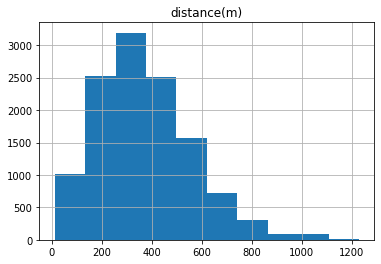

In [32]:
df_pred.hist('distance(m)')
plt.show()

In [33]:
n_rows = df_pred.shape[0]
list_1seg, list_2seg, list_3seg, list_4seg, list_5seg = \
  [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows

for i in range(n_rows):
    if i%5 == 0:
        list_1seg[i] = True
    elif i%5 == 1:
        list_2seg[i] = True
    elif i%5 == 2:
        list_3seg[i] = True
    elif i%5 == 3:
        list_4seg[i] = True
    elif i%5 == 4:
        list_5seg[i] = True

df_pred_1seg = df_pred.iloc[list_1seg, :]
df_pred_2seg = df_pred.iloc[list_2seg, :]
df_pred_3seg = df_pred.iloc[list_3seg, :]
df_pred_4seg = df_pred.iloc[list_4seg, :]
df_pred_5seg = df_pred.iloc[list_5seg, :]

In [34]:
print("Segundo 1: [{}, {}]".format(min(df_pred_1seg['distance(m)']),
                                   max(df_pred_1seg['distance(m)'])))
print("Segundo 2: [{}, {}]".format(min(df_pred_2seg['distance(m)']),
                                   max(df_pred_2seg['distance(m)'])))
print("Segundo 3: [{}, {}]".format(min(df_pred_3seg['distance(m)']),
                                   max(df_pred_3seg['distance(m)'])))
print("Segundo 4: [{}, {}]".format(min(df_pred_4seg['distance(m)']),
                                   max(df_pred_4seg['distance(m)'])))
print("Segundo 5: [{}, {}]".format(min(df_pred_5seg['distance(m)']),
                                   max(df_pred_5seg['distance(m)'])))

Segundo 1: [14.637620604887237, 1214.1422706776702]
Segundo 2: [12.996312817433408, 1218.8841255543139]
Segundo 3: [12.240309296859252, 1222.7987965237367]
Segundo 4: [11.47682089556262, 1225.9529162345964]
Segundo 5: [12.032439742823058, 1229.0909176069251]


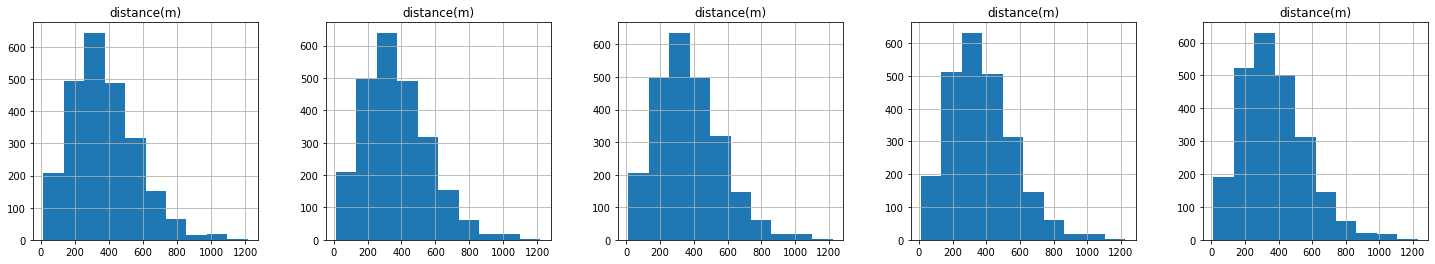

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25,4))
df_pred_1seg.hist('distance(m)', ax=ax[0])
df_pred_2seg.hist('distance(m)', ax=ax[1])
df_pred_3seg.hist('distance(m)', ax=ax[2])
df_pred_4seg.hist('distance(m)', ax=ax[3])
df_pred_5seg.hist('distance(m)', ax=ax[4])
plt.show()

In [36]:
df_pred_1seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.397941,2.148763,182.724116,5.190396,-0.094734,41.396994,2.149619,184.171392,5.743007,0.164075,368.445085
std,0.001181,0.001712,95.411211,4.690580,0.177053,0.002307,0.003671,98.232361,5.102721,1.308594,191.471358
min,41.393599,2.138493,10.362067,-8.213990,-1.173638,41.390906,2.139125,0.939814,0.000000,-10.000000,14.637621
25%,41.397220,2.147370,106.234109,0.287683,-0.223496,41.395245,2.147242,101.919406,0.172846,-0.104516,226.257868
50%,41.397743,2.149261,154.623529,5.074794,-0.036628,41.396960,2.149929,155.247244,4.966377,0.000000,344.732239
75%,41.398845,2.150238,258.871906,9.290196,0.028193,41.398961,2.151950,256.275266,10.340684,0.774525,481.744423
max,41.401944,2.152622,322.409318,13.332222,0.692792,41.401814,2.158624,357.404922,16.640354,5.988961,1214.142271


In [37]:
df_pred_2seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.397953,2.148758,183.097554,5.072682,-0.106016,41.396996,2.149621,184.160835,5.890808,0.147801,368.869311
std,0.001172,0.001723,94.282263,4.486045,0.231852,0.002308,0.003673,98.298534,4.947635,1.448525,191.958112
min,41.393579,2.138405,5.358219,-7.276585,-0.790094,41.390873,2.139078,0.939814,0.000000,-10.000000,12.996313
25%,41.397230,2.147335,108.205488,0.350140,-0.252563,41.395234,2.147314,101.844412,0.968818,-0.154634,225.574741
50%,41.397762,2.149251,155.322424,5.073424,-0.028813,41.396960,2.149913,155.264593,5.239587,0.030756,345.303883
75%,41.398843,2.150254,260.570502,9.029803,0.067460,41.398949,2.151951,256.443895,9.990617,0.898349,483.117405
max,41.401876,2.152745,322.194034,12.833643,0.696568,41.401864,2.158743,358.402101,16.602367,5.993102,1218.884126


In [38]:
df_pred_3seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.397963,2.148748,183.421252,4.943894,-0.094357,41.396996,2.149623,184.186244,6.081826,0.191018,369.313634
std,0.001163,0.001734,92.744088,4.228526,0.294378,0.002308,0.003675,98.566199,4.650839,1.636780,192.473457
min,41.393572,2.138305,10.224582,-6.367139,-0.950034,41.390836,2.139009,0.373142,0.000000,-9.706740,12.240309
25%,41.397243,2.147296,108.966417,0.436728,-0.290820,41.395221,2.147382,103.263678,2.096294,-0.201319,226.181521
50%,41.397787,2.149303,155.729201,5.172683,0.026771,41.396951,2.149961,155.606261,5.454008,0.089373,345.830122
75%,41.398848,2.150241,261.636890,8.762231,0.139840,41.398932,2.151952,262.182490,9.341440,1.054450,486.046715
max,41.401807,2.152856,321.381473,12.161527,0.910670,41.401915,2.158883,359.323010,16.546956,5.998546,1222.798797


In [39]:
df_pred_4seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.397965,2.148738,183.819694,4.754562,-0.157729,41.396997,2.149625,183.173735,6.130936,0.049110,369.455166
std,0.001156,0.001746,91.260524,3.952843,0.297585,0.002309,0.003675,99.410339,4.357840,1.918388,192.927153
min,41.393576,2.138199,17.034070,-5.765856,-0.921516,41.390802,2.138863,2.280386,0.000000,-10.000000,11.476821
25%,41.397260,2.147270,108.697384,0.490342,-0.359848,41.395206,2.147430,94.463904,2.726005,-0.410908,226.188443
50%,41.397799,2.149346,156.366269,5.179668,-0.040953,41.396931,2.150051,160.120137,5.748746,0.085084,346.202540
75%,41.398857,2.150224,262.197205,8.384742,0.075202,41.398903,2.151970,268.070273,8.739849,1.113957,487.425930
max,41.401732,2.152956,319.763048,11.356422,0.615675,41.401967,2.158981,359.017348,16.626126,5.996870,1225.952916


In [40]:
df_pred_5seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.397958,2.148724,183.804834,4.617217,-0.133172,41.396997,2.149628,176.707990,6.117309,0.105156,369.182648
std,0.001152,0.001758,89.503524,3.721500,0.245584,0.002309,0.003675,100.425471,4.092248,1.903228,193.434903
min,41.393593,2.138089,21.395847,-5.192957,-0.785386,41.390767,2.138725,0.598478,0.000000,-10.000000,12.032440
25%,41.397257,2.147233,108.888894,0.573942,-0.309493,41.395191,2.147420,74.637179,3.188963,-0.242367,224.892357
50%,41.397815,2.149363,156.733378,5.155868,-0.045052,41.396900,2.150056,147.086299,6.220898,0.103251,346.184937
75%,41.398851,2.150214,261.572542,8.043845,0.063526,41.398873,2.151995,261.391452,8.441894,1.059701,485.487264
max,41.401653,2.153048,316.456444,11.301586,0.561150,41.402028,2.159084,359.352131,16.601876,5.982253,1229.090918


In [41]:
# Load fitted model 
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "simple_v3", "LSTM_32units")
MODEL_FILE = os.path.join(MODEL_FOLDER, "model_saved.hdf5")
model = tf.keras.models.load_model(MODEL_FILE, compile=False) #https://stackoverflow.com/questions/48373845/loading-model-with-custom-loss-keras

# Get test metrics
METRICS_FILE = os.path.join(MODEL_FOLDER, "metrics.txt")
get_metrics(model, X_test, df, vehicle_ids, df_col, df_nocol, df_dim, METRICS_FILE)

coinciden y colisionan: 2120
0
100
200
300
400
500
600
700
800
900
1000
1100
coinciden pero no colisionan: 2120
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
false_positive: 13
true_negative: 1187
Total colision: 1200
TP: 5
FN: 1195
Total no colision: 1200
FP: 13
TN: 1187

Accuracy: 0.49666666666666665
Precision: 0.2777777777777778
Recall: 0.004166666666666667
F1 Score: 0.008210180623973728
Specificity: 0.9891666666666666


In [16]:
def make_gru_model(units, in_steps, out_steps, in_features, out_features):
    gru_model = Sequential()

    # Shape [batch, time, in_features] => [batch, gru_units].
    gru_model.add(GRU(units, input_shape=(in_steps, in_features)))

    # Shape => [batch, out_steps*out_features].
    gru_model.add(Dense(out_steps*out_features))

    # Shape => [batch, out_steps, out_features].
    gru_model.add(Reshape([out_steps, out_features]))

    gru_model.summary()

    return gru_model

In [43]:
# Create model folder
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "simple_v3", "GRU_32units")
os.makedirs(MODEL_FOLDER, exist_ok=True)

# Model parameters
GRU_UNITS=32

# Create, compile and fit model
gru_model = make_gru_model(GRU_UNITS, INPUT_WIDTH, OUTPUT_WIDTH,
                             len(INPUT_COL), len(OUTPUT_COL))
history = compile_and_fit(gru_model, X_train, y_train, X_val, y_val,
                          MODEL_FOLDER, epochs=EPOCHS, batch_size=BATCH_SIZE,
                          patience=PATIENCE, reduce_lr=REDUCELR)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 32)                3744      
                                                                 
 dense_2 (Dense)             (None, 25)                825       
                                                                 
 reshape_2 (Reshape)         (None, 5, 5)              0         
                                                                 
Total params: 4,569
Trainable params: 4,569
Non-trainable params: 0
_________________________________________________________________
X_train.shape: (6005877, 20, 5)
y_train.shape: (6005877, 5, 5)
Epoch 1/10
93842/93842 [==============================] - 11905s 127ms/step - loss: 340.5230 - mean_absolute_error: 3.0958 - val_loss: 90.6833 - val_mean_absolute_error: 1.4514 - lr: 0.0010
Epoch 2/10
93842/93842 [==============================] - 11035

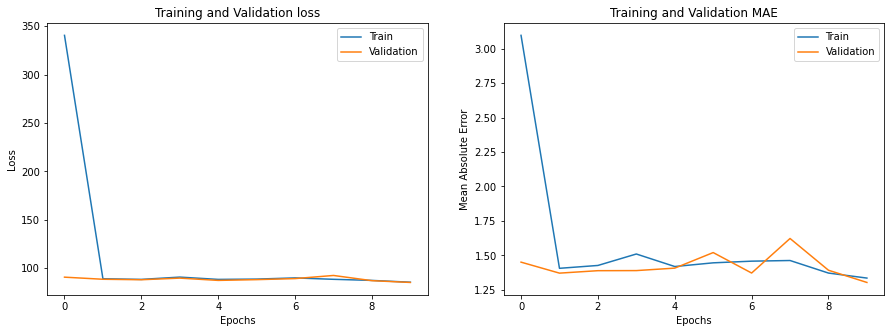

In [44]:
plot_history(history.history)

In [45]:
df_pred = model_predictions(lstm_model, X_test, y_test)
print("Distance(m): [{}, {}]".format(min(df_pred['distance(m)']),
                                     max(df_pred['distance(m)'])))
df_pred

76/76 [==============================] - 3s 35ms/step
Distance(m): [11.47682089556262, 1229.0909176069251]


,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
0,41.396073,2.151407,74.500323,0.221364,0.037089,41.394340,2.151350,72.348077,0.000000,0.000000,192.802875
1,41.396084,2.151411,74.297900,0.313748,0.112511,41.394340,2.151350,72.348077,0.000000,0.000000,194.030691
2,41.396097,2.151414,73.939017,0.411895,0.137009,41.394340,2.151350,72.348077,0.000000,0.000000,195.408045
3,41.396105,2.151413,73.589915,0.507940,0.141515,41.394340,2.151350,72.348077,0.000000,0.000000,196.311275
4,41.396104,2.151412,73.243564,0.596356,0.089663,41.394340,2.151350,72.348077,0.000000,0.000000,196.227238
...,...,...,...,...,...,...,...,...,...,...,...
12005,41.400195,2.150548,48.143189,7.115127,0.074038,41.400268,2.151179,44.652289,7.775367,0.289365,53.294631
12006,41.400284,2.150582,48.910915,7.281845,0.202846,41.400317,2.151234,39.488036,7.149873,-0.625495,54.461930
12007,41.400370,2.150613,50.891948,7.399745,0.190914,41.400383,2.151277,23.947936,8.208109,1.058236,55.358243
12008,41.400448,2.150638,53.744122,7.472951,0.162865,41.400452,2.151264,348.255669,8.071555,-0.136553,52.174179


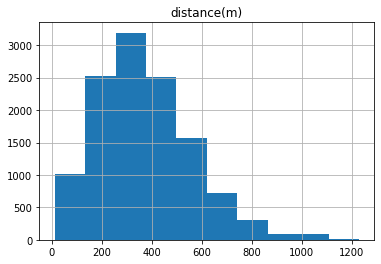

In [46]:
df_pred.hist('distance(m)')
plt.show()

In [47]:
n_rows = df_pred.shape[0]
list_1seg, list_2seg, list_3seg, list_4seg, list_5seg = \
  [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows

for i in range(n_rows):
    if i%5 == 0:
        list_1seg[i] = True
    elif i%5 == 1:
        list_2seg[i] = True
    elif i%5 == 2:
        list_3seg[i] = True
    elif i%5 == 3:
        list_4seg[i] = True
    elif i%5 == 4:
        list_5seg[i] = True

df_pred_1seg = df_pred.iloc[list_1seg, :]
df_pred_2seg = df_pred.iloc[list_2seg, :]
df_pred_3seg = df_pred.iloc[list_3seg, :]
df_pred_4seg = df_pred.iloc[list_4seg, :]
df_pred_5seg = df_pred.iloc[list_5seg, :]

In [48]:
print("Segundo 1: [{}, {}]".format(min(df_pred_1seg['distance(m)']),
                                   max(df_pred_1seg['distance(m)'])))
print("Segundo 2: [{}, {}]".format(min(df_pred_2seg['distance(m)']),
                                   max(df_pred_2seg['distance(m)'])))
print("Segundo 3: [{}, {}]".format(min(df_pred_3seg['distance(m)']),
                                   max(df_pred_3seg['distance(m)'])))
print("Segundo 4: [{}, {}]".format(min(df_pred_4seg['distance(m)']),
                                   max(df_pred_4seg['distance(m)'])))
print("Segundo 5: [{}, {}]".format(min(df_pred_5seg['distance(m)']),
                                   max(df_pred_5seg['distance(m)'])))

Segundo 1: [14.637620604887237, 1214.1422706776702]
Segundo 2: [12.996312817433408, 1218.8841255543139]
Segundo 3: [12.240309296859252, 1222.7987965237367]
Segundo 4: [11.47682089556262, 1225.9529162345964]
Segundo 5: [12.032439742823058, 1229.0909176069251]


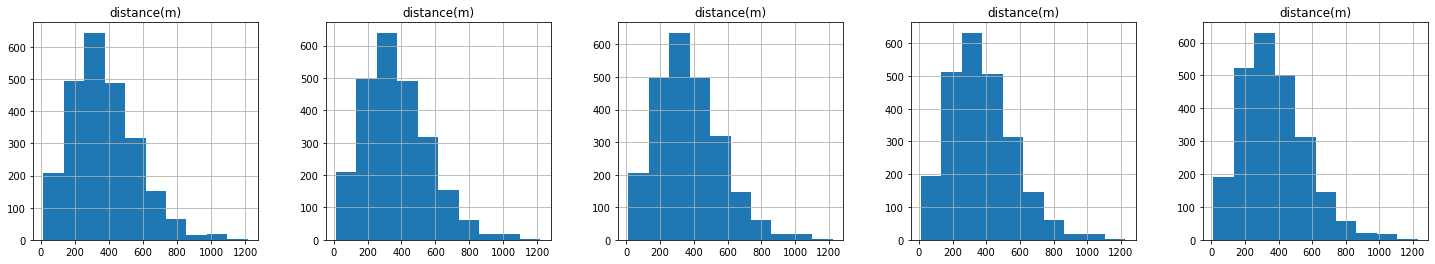

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25,4))
df_pred_1seg.hist('distance(m)', ax=ax[0])
df_pred_2seg.hist('distance(m)', ax=ax[1])
df_pred_3seg.hist('distance(m)', ax=ax[2])
df_pred_4seg.hist('distance(m)', ax=ax[3])
df_pred_5seg.hist('distance(m)', ax=ax[4])
plt.show()

In [50]:
df_pred_1seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.397941,2.148763,182.724116,5.190396,-0.094734,41.396994,2.149619,184.171392,5.743007,0.164075,368.445085
std,0.001181,0.001712,95.411211,4.690580,0.177053,0.002307,0.003671,98.232361,5.102721,1.308594,191.471358
min,41.393599,2.138493,10.362067,-8.213990,-1.173638,41.390906,2.139125,0.939814,0.000000,-10.000000,14.637621
25%,41.397220,2.147370,106.234109,0.287683,-0.223496,41.395245,2.147242,101.919406,0.172846,-0.104516,226.257868
50%,41.397743,2.149261,154.623529,5.074794,-0.036628,41.396960,2.149929,155.247244,4.966377,0.000000,344.732239
75%,41.398845,2.150238,258.871906,9.290196,0.028193,41.398961,2.151950,256.275266,10.340684,0.774525,481.744423
max,41.401944,2.152622,322.409318,13.332222,0.692792,41.401814,2.158624,357.404922,16.640354,5.988961,1214.142271


In [51]:
df_pred_2seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.397953,2.148758,183.097554,5.072682,-0.106016,41.396996,2.149621,184.160835,5.890808,0.147801,368.869311
std,0.001172,0.001723,94.282263,4.486045,0.231852,0.002308,0.003673,98.298534,4.947635,1.448525,191.958112
min,41.393579,2.138405,5.358219,-7.276585,-0.790094,41.390873,2.139078,0.939814,0.000000,-10.000000,12.996313
25%,41.397230,2.147335,108.205488,0.350140,-0.252563,41.395234,2.147314,101.844412,0.968818,-0.154634,225.574741
50%,41.397762,2.149251,155.322424,5.073424,-0.028813,41.396960,2.149913,155.264593,5.239587,0.030756,345.303883
75%,41.398843,2.150254,260.570502,9.029803,0.067460,41.398949,2.151951,256.443895,9.990617,0.898349,483.117405
max,41.401876,2.152745,322.194034,12.833643,0.696568,41.401864,2.158743,358.402101,16.602367,5.993102,1218.884126


In [52]:
df_pred_3seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.397963,2.148748,183.421252,4.943894,-0.094357,41.396996,2.149623,184.186244,6.081826,0.191018,369.313634
std,0.001163,0.001734,92.744088,4.228526,0.294378,0.002308,0.003675,98.566199,4.650839,1.636780,192.473457
min,41.393572,2.138305,10.224582,-6.367139,-0.950034,41.390836,2.139009,0.373142,0.000000,-9.706740,12.240309
25%,41.397243,2.147296,108.966417,0.436728,-0.290820,41.395221,2.147382,103.263678,2.096294,-0.201319,226.181521
50%,41.397787,2.149303,155.729201,5.172683,0.026771,41.396951,2.149961,155.606261,5.454008,0.089373,345.830122
75%,41.398848,2.150241,261.636890,8.762231,0.139840,41.398932,2.151952,262.182490,9.341440,1.054450,486.046715
max,41.401807,2.152856,321.381473,12.161527,0.910670,41.401915,2.158883,359.323010,16.546956,5.998546,1222.798797


In [53]:
df_pred_4seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.397965,2.148738,183.819694,4.754562,-0.157729,41.396997,2.149625,183.173735,6.130936,0.049110,369.455166
std,0.001156,0.001746,91.260524,3.952843,0.297585,0.002309,0.003675,99.410339,4.357840,1.918388,192.927153
min,41.393576,2.138199,17.034070,-5.765856,-0.921516,41.390802,2.138863,2.280386,0.000000,-10.000000,11.476821
25%,41.397260,2.147270,108.697384,0.490342,-0.359848,41.395206,2.147430,94.463904,2.726005,-0.410908,226.188443
50%,41.397799,2.149346,156.366269,5.179668,-0.040953,41.396931,2.150051,160.120137,5.748746,0.085084,346.202540
75%,41.398857,2.150224,262.197205,8.384742,0.075202,41.398903,2.151970,268.070273,8.739849,1.113957,487.425930
max,41.401732,2.152956,319.763048,11.356422,0.615675,41.401967,2.158981,359.017348,16.626126,5.996870,1225.952916


In [54]:
df_pred_5seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.397958,2.148724,183.804834,4.617217,-0.133172,41.396997,2.149628,176.707990,6.117309,0.105156,369.182648
std,0.001152,0.001758,89.503524,3.721500,0.245584,0.002309,0.003675,100.425471,4.092248,1.903228,193.434903
min,41.393593,2.138089,21.395847,-5.192957,-0.785386,41.390767,2.138725,0.598478,0.000000,-10.000000,12.032440
25%,41.397257,2.147233,108.888894,0.573942,-0.309493,41.395191,2.147420,74.637179,3.188963,-0.242367,224.892357
50%,41.397815,2.149363,156.733378,5.155868,-0.045052,41.396900,2.150056,147.086299,6.220898,0.103251,346.184937
75%,41.398851,2.150214,261.572542,8.043845,0.063526,41.398873,2.151995,261.391452,8.441894,1.059701,485.487264
max,41.401653,2.153048,316.456444,11.301586,0.561150,41.402028,2.159084,359.352131,16.601876,5.982253,1229.090918


In [55]:
# Load fitted model 
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "simple_v3", "GRU_32units")
MODEL_FILE = os.path.join(MODEL_FOLDER, "model_saved.hdf5")
model = tf.keras.models.load_model(MODEL_FILE, compile=False) #https://stackoverflow.com/questions/48373845/loading-model-with-custom-loss-keras

# Get test metrics
METRICS_FILE = os.path.join(MODEL_FOLDER, "metrics.txt")
get_metrics(model, X_test, df, vehicle_ids, df_col, df_nocol, df_dim, METRICS_FILE)

coinciden y colisionan: 2120
0
100
200
300
400
500
600
700
800
900
1000
1100
coinciden pero no colisionan: 2120
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
false_positive: 13
true_negative: 1187
Total colision: 1200
TP: 4
FN: 1196
Total no colision: 1200
FP: 13
TN: 1187

Accuracy: 0.49625
Precision: 0.23529411764705882
Recall: 0.0033333333333333335
F1 Score: 0.006573541495480691
Specificity: 0.9891666666666666


In [17]:
# Create model folder
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "simple_v3", "GRU_64units")
os.makedirs(MODEL_FOLDER, exist_ok=True)

# Model parameters
GRU_UNITS=64

# Create, compile and fit model
gru_model = make_gru_model(GRU_UNITS, INPUT_WIDTH, OUTPUT_WIDTH,
                             len(INPUT_COL), len(OUTPUT_COL))
history = compile_and_fit(gru_model, X_train, y_train, X_val, y_val,
                          MODEL_FOLDER, epochs=EPOCHS, batch_size=BATCH_SIZE,
                          patience=PATIENCE, reduce_lr=REDUCELR)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                13632     
                                                                 
 dense (Dense)               (None, 25)                1625      
                                                                 
 reshape (Reshape)           (None, 5, 5)              0         
                                                                 
Total params: 15,257
Trainable params: 15,257
Non-trainable params: 0
_________________________________________________________________
X_train.shape: (6005877, 20, 5)
y_train.shape: (6005877, 5, 5)
Epoch 1/10
93842/93842 [==============================] - 11409s 122ms/step - loss: 225.9390 - mean_absolute_error: 2.3340 - val_loss: 87.5935 - val_mean_absolute_error: 1.3797 - lr: 0.0010
Epoch 2/10
93842/93842 [==============================] - 11920

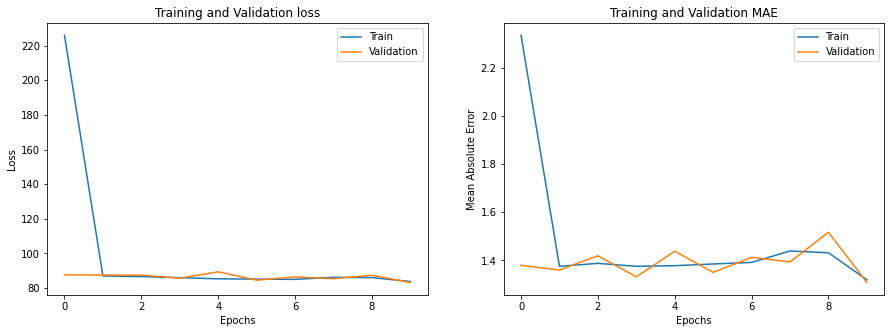

In [18]:
plot_history(history.history)

In [20]:
df_pred = model_predictions(gru_model, X_test, y_test)
print("Distance(m): [{}, {}]".format(min(df_pred['distance(m)']),
                                     max(df_pred['distance(m)'])))
df_pred

76/76 [==============================] - 2s 26ms/step
Distance(m): [0.7694345587240944, 5923.547957187516]


,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
0,41.396229,2.150591,72.974266,0.175982,0.044811,41.394340,2.151350,72.348077,0.000000,0.000000,219.412181
1,41.396249,2.150585,72.725958,0.264255,0.090331,41.394340,2.151350,72.348077,0.000000,0.000000,221.668343
2,41.396192,2.150577,72.917017,0.360834,0.109561,41.394340,2.151350,72.348077,0.000000,0.000000,215.758666
3,41.396272,2.150571,73.274304,0.470168,0.104236,41.394340,2.151350,72.348077,0.000000,0.000000,224.403363
4,41.396224,2.150566,73.578180,0.566175,0.095912,41.394340,2.151350,72.348077,0.000000,0.000000,219.426130
...,...,...,...,...,...,...,...,...,...,...,...
12005,41.399701,2.146971,43.120334,7.964087,-0.011956,41.400268,2.151179,44.652289,7.775367,0.289365,356.628285
12006,41.399744,2.147006,49.673624,7.933671,-0.000649,41.400317,2.151234,39.488036,7.149873,-0.625495,358.347017
12007,41.399778,2.147053,55.920799,7.913240,-0.006240,41.400383,2.151277,23.947936,8.208109,1.058236,358.696318
12008,41.399822,2.147095,61.966621,7.960451,-0.002973,41.400452,2.151264,348.255669,8.071555,-0.136553,354.712649


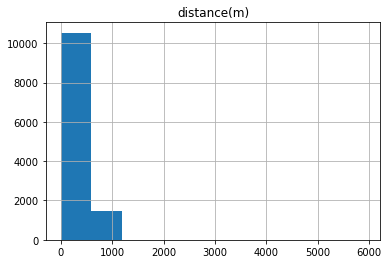

In [21]:
df_pred.hist('distance(m)')
plt.show()

In [22]:
n_rows = df_pred.shape[0]
list_1seg, list_2seg, list_3seg, list_4seg, list_5seg = \
  [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows

for i in range(n_rows):
    if i%5 == 0:
        list_1seg[i] = True
    elif i%5 == 1:
        list_2seg[i] = True
    elif i%5 == 2:
        list_3seg[i] = True
    elif i%5 == 3:
        list_4seg[i] = True
    elif i%5 == 4:
        list_5seg[i] = True

df_pred_1seg = df_pred.iloc[list_1seg, :]
df_pred_2seg = df_pred.iloc[list_2seg, :]
df_pred_3seg = df_pred.iloc[list_3seg, :]
df_pred_4seg = df_pred.iloc[list_4seg, :]
df_pred_5seg = df_pred.iloc[list_5seg, :]

In [23]:
print("Segundo 1: [{}, {}]".format(min(df_pred_1seg['distance(m)']),
                                   max(df_pred_1seg['distance(m)'])))
print("Segundo 2: [{}, {}]".format(min(df_pred_2seg['distance(m)']),
                                   max(df_pred_2seg['distance(m)'])))
print("Segundo 3: [{}, {}]".format(min(df_pred_3seg['distance(m)']),
                                   max(df_pred_3seg['distance(m)'])))
print("Segundo 4: [{}, {}]".format(min(df_pred_4seg['distance(m)']),
                                   max(df_pred_4seg['distance(m)'])))
print("Segundo 5: [{}, {}]".format(min(df_pred_5seg['distance(m)']),
                                   max(df_pred_5seg['distance(m)'])))

Segundo 1: [6.067153931293033, 4941.31366978497]
Segundo 2: [4.988109452819735, 5302.066044009642]
Segundo 3: [0.7694345587240944, 4675.474456095992]
Segundo 4: [6.222284503993572, 5923.547957187516]
Segundo 5: [15.747664913563492, 5403.407001902925]


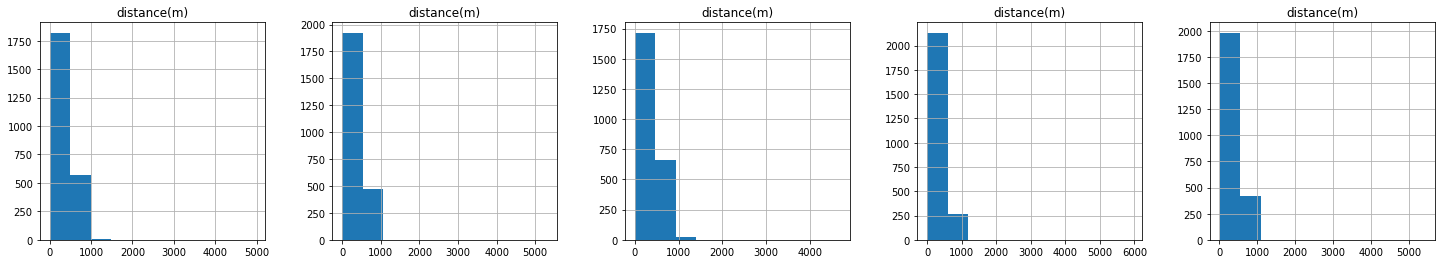

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25,4))
df_pred_1seg.hist('distance(m)', ax=ax[0])
df_pred_2seg.hist('distance(m)', ax=ax[1])
df_pred_3seg.hist('distance(m)', ax=ax[2])
df_pred_4seg.hist('distance(m)', ax=ax[3])
df_pred_5seg.hist('distance(m)', ax=ax[4])
plt.show()

In [25]:
df_pred_1seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.398477,2.148971,183.941759,5.092174,-0.094501,41.396994,2.149619,184.171392,5.743007,0.164075,380.431606
std,0.001688,0.001529,96.443462,4.461020,0.140586,0.002307,0.003671,98.232361,5.102721,1.308594,210.277156
min,41.392486,2.142621,12.996933,-1.917908,-0.995256,41.390906,2.139125,0.939814,0.000000,-10.000000,6.067154
25%,41.397177,2.148096,108.122194,0.355301,-0.171821,41.395245,2.147242,101.919406,0.172846,-0.104516,230.090017
50%,41.398268,2.149211,154.877964,7.014835,-0.078466,41.396960,2.149929,155.247244,4.966377,0.000000,371.264316
75%,41.399687,2.150008,261.078607,8.715954,0.013895,41.398961,2.151950,256.275266,10.340684,0.774525,494.672110
max,41.440378,2.153767,336.946930,14.463158,0.424120,41.401814,2.158624,357.404922,16.640354,5.988961,4941.313670


In [26]:
df_pred_2seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.398481,2.148970,183.841441,4.984980,-0.096439,41.396996,2.149621,184.160835,5.890808,0.147801,381.310271
std,0.001729,0.001515,94.974579,4.273731,0.202249,0.002308,0.003673,98.298534,4.947635,1.448525,214.424065
min,41.391077,2.142678,10.310050,-1.574651,-0.731421,41.390873,2.139078,0.939814,0.000000,-10.000000,4.988109
25%,41.397181,2.148096,108.560479,0.423304,-0.224421,41.395234,2.147314,101.844412,0.968818,-0.154634,229.645328
50%,41.398274,2.149239,155.203092,6.980496,-0.044655,41.396960,2.149913,155.264593,5.239587,0.030756,373.343786
75%,41.399712,2.150023,258.962347,8.506335,0.054075,41.398949,2.151951,256.443895,9.990617,0.898349,497.957544
max,41.443626,2.153856,334.403569,13.815033,0.511691,41.401864,2.158743,358.402101,16.602367,5.993102,5302.066044


In [27]:
df_pred_3seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.398446,2.148967,183.943395,4.869174,-0.099974,41.396996,2.149623,184.186244,6.081826,0.191018,379.649032
std,0.001659,0.001503,93.529362,4.058511,0.241161,0.002308,0.003675,98.566199,4.650839,1.636780,208.895616
min,41.392424,2.142570,8.997703,-1.310152,-0.890662,41.390836,2.139009,0.373142,0.000000,-9.706740,0.769435
25%,41.397177,2.148102,109.399810,0.521216,-0.256132,41.395221,2.147382,103.263678,2.096294,-0.201319,230.690282
50%,41.398214,2.149226,155.504142,6.846853,-0.056568,41.396951,2.149961,155.606261,5.454008,0.089373,372.521502
75%,41.399698,2.150038,258.244519,8.245930,0.104703,41.398932,2.151952,262.182490,9.341440,1.054450,497.091336
max,41.437979,2.153940,331.413286,13.224067,0.552406,41.401915,2.158883,359.323010,16.546956,5.998546,4675.474456


In [28]:
df_pred_4seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.398477,2.148966,184.101531,4.738597,-0.149877,41.396997,2.149625,183.173735,6.130936,0.049110,382.200657
std,0.001799,0.001491,92.184971,3.843871,0.248723,0.002309,0.003675,99.410339,4.357840,1.918388,221.791276
min,41.391276,2.142627,8.677905,-1.157511,-0.838765,41.390802,2.138863,2.280386,0.000000,-10.000000,6.222285
25%,41.397172,2.148101,109.795587,0.611461,-0.336470,41.395206,2.147430,94.463904,2.726005,-0.410908,230.597499
50%,41.398235,2.149208,155.518581,6.664468,-0.118179,41.396931,2.150051,160.120137,5.748746,0.085084,374.265478
75%,41.399702,2.150037,257.916544,7.969956,0.058118,41.398903,2.151970,268.070273,8.739849,1.113957,498.530460
max,41.449212,2.154020,328.211977,12.675376,0.485768,41.401967,2.158981,359.017348,16.626126,5.996870,5923.547957


In [29]:
df_pred_5seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.398445,2.148963,183.998939,4.626589,-0.108918,41.396997,2.149628,176.707990,6.117309,0.105156,380.600752
std,0.001739,0.001480,90.649097,3.651176,0.218135,0.002309,0.003675,100.425471,4.092248,1.903228,216.690590
min,41.390974,2.142755,4.243253,-0.985271,-0.657108,41.390767,2.138725,0.598478,0.000000,-10.000000,15.747665
25%,41.397174,2.148090,109.949317,0.697225,-0.285240,41.395191,2.147420,74.637179,3.188963,-0.242367,230.166487
50%,41.398195,2.149185,155.651075,6.446011,-0.096618,41.396900,2.150056,147.086299,6.220898,0.103251,374.090774
75%,41.399678,2.150047,257.833660,7.697399,0.080374,41.398873,2.151995,261.391452,8.441894,1.059701,496.770780
max,41.444538,2.154094,324.307279,12.217963,0.491970,41.402028,2.159084,359.352131,16.601876,5.982253,5403.407002


In [30]:
# Load fitted model 
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "simple_v3", "GRU_64units")
MODEL_FILE = os.path.join(MODEL_FOLDER, "model_saved.hdf5")
model = tf.keras.models.load_model(MODEL_FILE, compile=False) #https://stackoverflow.com/questions/48373845/loading-model-with-custom-loss-keras

# Get test metrics
METRICS_FILE = os.path.join(MODEL_FOLDER, "metrics.txt")
get_metrics(model, X_test, df, vehicle_ids, df_col, df_nocol, df_dim, METRICS_FILE)

coinciden y colisionan: 2120
0
100
200
300
400
500
600
700
800
900
1000
1100
coinciden pero no colisionan: 2120
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
false_positive: 21
true_negative: 1179
Total colision: 1200
TP: 6
FN: 1194
Total no colision: 1200
FP: 21
TN: 1179

Accuracy: 0.49375
Precision: 0.2222222222222222
Recall: 0.005
F1 Score: 0.009779951100244499
Specificity: 0.9825
